# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
import seaborn as sb
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import time
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Preprocessing Features

## Feature Transformation

In [3]:
df = pd.read_csv('netflix.csv') # dataset file

# preprocessing features
df['d'] = pd.to_datetime(df['Date'])
df['Y'] = df['d'].dt.year # converting the Date feature to three sub-features: year, month, day
df['M'] = df['d'].dt.month
df['D'] = df['d'].dt.day
df['Volume_log'] = np.log1p(df['Volume']) # Adding 1 to handle zeros# reducing outlier impact by taking the log of the shares
df['Volume_log'] = df['Volume_log'].clip(lower=df['Volume_log'].quantile(0.01), upper=df['Volume_log'].quantile(0.99))
df['target'] = df['Volume_log'] # We want to predict the total number of shares that will be sold

df = df.dropna() # removing any NaN values from the data frame, if any

## Feature Selection

In [5]:
features = ['Open', 'High', 'Low', 'Close', 'Y', 'M', 'D']
input = df[features] # input features, X
volume = df['target'] # prediction target feature, y

### Data Distribution

<Axes: xlabel='target', ylabel='Count'>

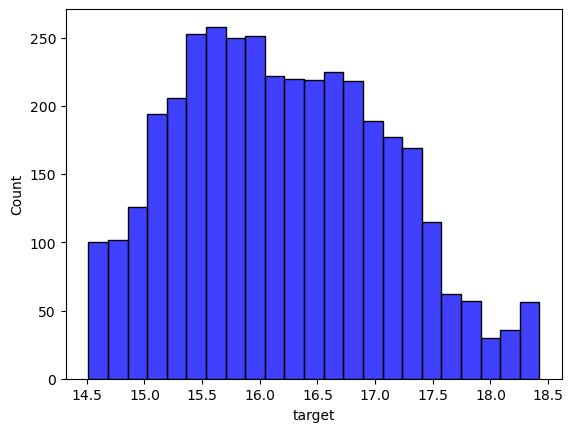

In [7]:
sb.histplot(data=volume, kde=False, color='blue')

### Scatterplot

<Axes: ylabel='target'>

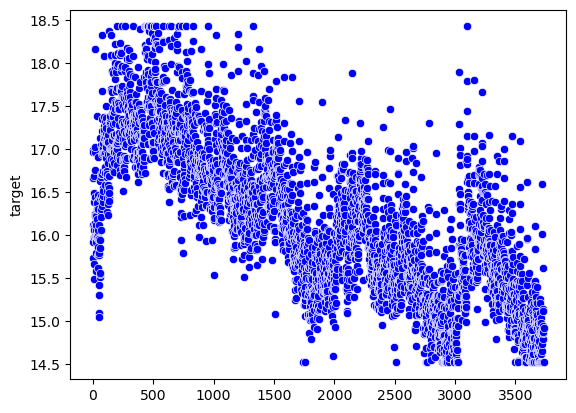

In [9]:
sb.scatterplot(data=volume, color='blue')

## Dataset Split

In [11]:
input_train, input_test, volume_train, volume_test = train_test_split( 
    input, volume, test_size=0.2, shuffle=True) # Splitting 80% of the data for training and 20% for testing
input_train, input_val, volume_train, volume_val = (
    train_test_split(input_train, volume_train, test_size=0.2, shuffle=True)) # Splitting 15% of the training data for validation

## Scaling

In [13]:
# Standardization/Normalization using a standard scaler
scaler_X = StandardScaler()
input_train_scaled = scaler_X.fit_transform(input_train)
input_val_scaled = scaler_X.transform(input_val)
input_test_scaled = scaler_X.transform(input_test)

# Standardizing the target variable (volume)
scaler_y = StandardScaler()
volume_train_scaled = scaler_y.fit_transform(volume_train.values.reshape(-1, 1)).flatten()
volume_val_scaled = scaler_y.transform(volume_val.values.reshape(-1, 1)).flatten()
volume_test_scaled = scaler_y.transform(volume_test.values.reshape(-1, 1)).flatten()

# Training the model

In [15]:
rf_model = RandomForestRegressor(bootstrap=True, max_depth=30, min_samples_split=30, min_samples_leaf=40, n_estimators=300)
rf_model.fit(input_train_scaled, volume_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=40, min_samples_split=30,
                      n_estimators=300)

## Training and Validation Metrics

In [17]:
# Predictions
train_preds = rf_model.predict(input_train_scaled)
val_preds = rf_model.predict(input_val_scaled)

# Compute error metrics
train_mse = mean_squared_error(volume_train, train_preds)
val_mse = mean_squared_error(volume_val, val_preds)

train_mae = mean_absolute_error(volume_train, train_preds)
val_mae = mean_absolute_error(volume_val, val_preds)

train_r2 = r2_score(volume_train, train_preds)
val_r2 = r2_score(volume_val, val_preds)

# Print results
print(f"Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Validation R²: {val_r2:.4f}")

Train MSE: 0.1833, Validation MSE: 0.2072
Train MAE: 0.3274, Validation MAE: 0.3448
Train R²: 0.7652, Validation R²: 0.7442


## Feature Importance

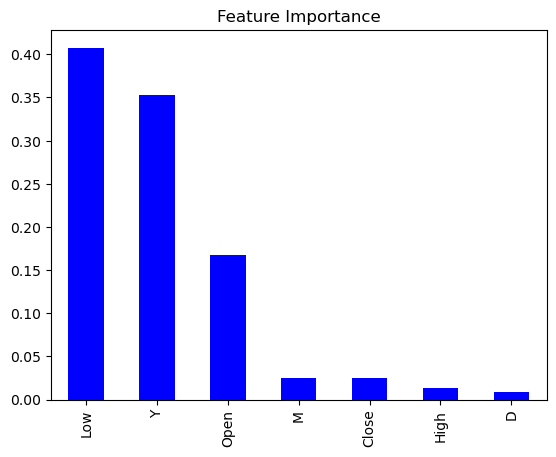

In [19]:
importances = pd.Series(rf_model.feature_importances_, index=input.columns)
importances.sort_values(ascending=False).plot(kind='bar', color = 'blue')
plt.title('Feature Importance')
plt.show()

## Hyperparameter tuning

### Grid search

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [ 200, 300, 400],
    'max_depth': [30, 40, None],
    'min_samples_split': [20, 30, 50],
    'min_samples_leaf': [20, 30, 40]
}

# Initialize model
rf_model = RandomForestRegressor(random_state=42, bootstrap=True)

# Initialize GridSearchCV with verbose logging
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=1,
    verbose=3  # Verbose level 3 prints updates for every model trained
)

print("Starting Grid Search...\n")
start_time = time.time()

# Fit the grid search to the data
grid_search.fit(input_train_scaled, volume_train_scaled)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nGrid Search Completed in {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes).")

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

train_preds = best_model.predict(input_train_scaled)
val_preds = best_model.predict(input_val_scaled)

# Compute error metrics on training data
train_mse = mean_squared_error(volume_train_scaled, train_preds)
train_mae = mean_absolute_error(volume_train_scaled, train_preds)
train_r2 = r2_score(volume_train_scaled, train_preds)

# Compute error metrics on validation data
val_mse = mean_squared_error(volume_val_scaled, val_preds)
val_mae = mean_absolute_error(volume_val_scaled, val_preds)
val_r2 = r2_score(volume_val_scaled, val_preds)

# Print the results
print("\nBest Parameters Found:", best_params)
print(f"Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Validation R²: {val_r2:.4f}")

### Bayesian search

In [ ]:
search_space = {
    'n_estimators': Integer(50, 600),  
    'max_depth': Integer(10, 50),  
    'min_samples_split': Integer(10, 50),  
    'min_samples_leaf': Integer(10, 50)  
}

rf_model = RandomForestRegressor(random_state=42, bootstrap=True)

bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_space,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=1,
    verbose=3,
    random_state=42
)

print("Starting Bayesian Optimization...\n")
bayes_search.fit(input_train_scaled, volume_train_scaled)

best_params = bayes_search.best_params_

train_preds = bayes_search.best_estimator_.predict(input_train_scaled)
val_preds = bayes_search.best_estimator_.predict(input_val_scaled)

# Compute error metrics on training data
train_mse = mean_squared_error(volume_train_scaled, train_preds)
train_mae = mean_absolute_error(volume_train_scaled, train_preds)
train_r2 = r2_score(volume_train_scaled, train_preds)

# Compute error metrics on validation data
val_mse = mean_squared_error(volume_val_scaled, val_preds)
val_mae = mean_absolute_error(volume_val_scaled, val_preds)
val_r2 = r2_score(volume_val_scaled, val_preds)

print("\nBest Parameters Found:", best_params)
print(f"Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Validation R²: {val_r2:.4f}")

# Testing

In [21]:
predictions = rf_model.predict(input_test_scaled)

## Training and Testing Metrics

In [23]:
test_mse = mean_squared_error(volume_test, predictions)
test_mae = mean_absolute_error(volume_test, predictions)
test_r2 = r2_score(volume_test, predictions)

print(f"Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Validation R²: {val_r2:.4f}, Test R²: {test_r2:.4f}")

Train MSE: 0.1833, Validation MSE: 0.2072, Test MSE: 0.2169
Train MAE: 0.3274, Validation MAE: 0.3448, Test MAE: 0.3622
Train R²: 0.7652, Validation R²: 0.7442, Test R²: 0.7394


## Prediction plot

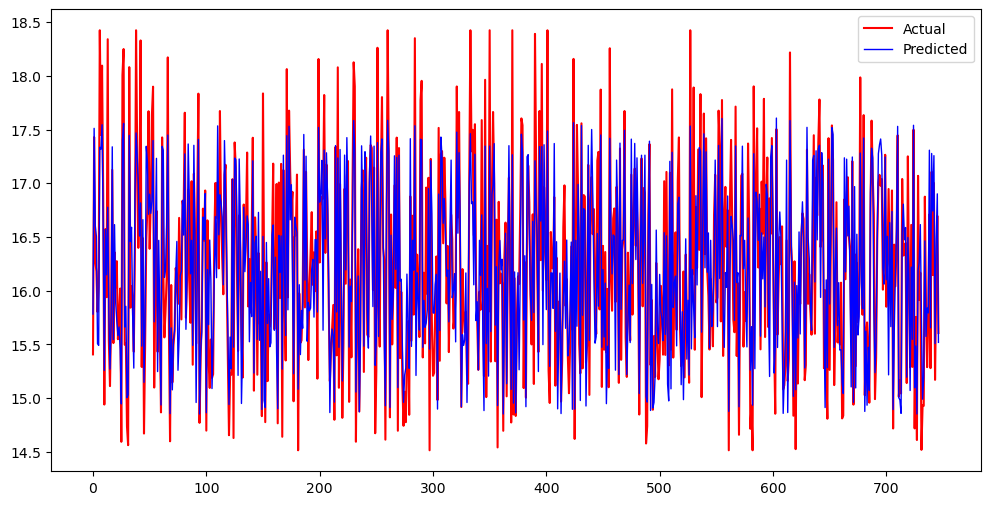

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(volume_test.values, label='Actual', color='red', linewidth=1.5)
plt.plot(predictions, label='Predicted', color='blue', linewidth=1.0)
plt.legend(loc='upper right')
plt.show()

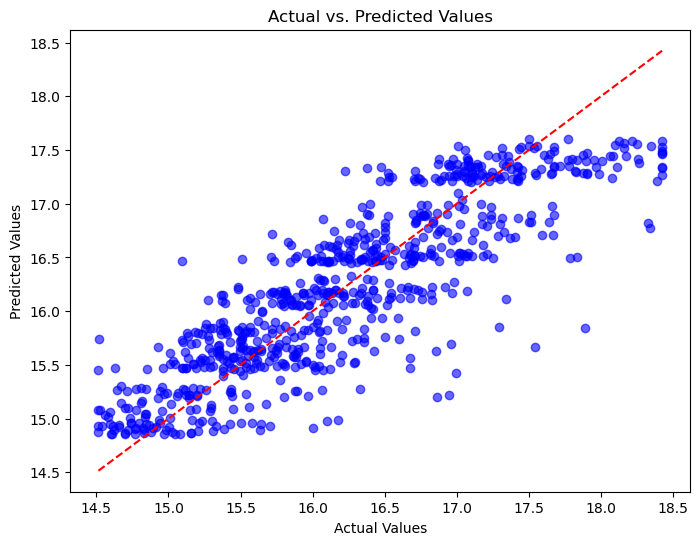

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(volume_test, predictions, alpha=0.6, color='blue')
plt.plot([min(volume_test), max(volume_test)], [min(volume_test), max(volume_test)], linestyle='dashed', color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()